# ML model using scorecard data

This notebook explores whether machine learning methods have better predictive abilities than the "traditional" data analytics approach of running a linear regression equation on all *a priori* explanatory variables (features), i.e. the "kitchen-sink" approach. This is done using data from the College Scorecard linked geographically to variables on economic conditions. Both these approaches are correlational in nature. No causal mechanism should be interpreted from the results.

This notebook is a continuation of an earlier notebook modeling/predicting the median earnings 10 years after enrolling at the institutional level. This notebook primarily examines whether transforming the median earnings into log levels will improve the predictions. 

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
# import missingno as miss

# Plotting libraries
# from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn import linear_model
from sklearn import impute

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RF
# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
# from sklearn.inspection import (
#     permutation_importance,
#     partial_dependence, 
#     PartialDependenceDisplay, 
#     plot_partial_dependence
# )

# import requests
# from bs4 import BeautifulSoup
from random import randint
# from time import sleep

import re
import time
import math
import operator

# Misc
import warnings
warnings.filterwarnings("ignore")

## Read data and get columns to use for ML

Note: race variables change depending on year of data collection. Not all variables are collected every year so only those with count > 0 are kept

In [2]:
def getdata(csvfile):
    # read csv file
    scard = pd.read_csv(csvfile, na_values = 'PrivacySuppressed')
    # get metadata on numeric values
    scard_metadata = scard.describe(include='all').transpose()
    # get column names of all variables and convert to df
    cols = scard.columns.values
    cols = pd.DataFrame(cols, columns = ['column_name'])
    # Extract column names for share of students in different majors
    major_cols = cols.loc[cols['column_name'].str.startswith('PCIP')]['column_name'].values.tolist()
    # Extract column names for race shares of students
    race_cols = cols.loc[cols['column_name'].str.startswith('UGDS_')]['column_name'].values.tolist()
    # List of other variables to use combined with majors and race
    cols_to_keep = ['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'MAIN', 'PREDDEG', 'CONTROL', 'ICLEVEL', 'ST_FIPS', 'LOCALE', 'CCBASIC', 'HIGHDEG',
    'ADM_RATE', 'SATVRMID', 'SATMTMID', 'SATWRMID', 'ACTCMMID', 'ACENMID', 'ACTMTMID', 'ACTWRMID', 'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'C150_L4', 'C150_4', 'RET_FT4',
    'RET_FTL4','OPENADMP', 'MD_EARN_WNE_P10', 'MD_EARN_WNE_P8', 'MD_EARN_WNE_P6'] + major_cols + race_cols
    vars_to_use = scard_metadata.filter(items=cols_to_keep, axis=0)
    # keep only meta data on variables that have values
    vars_to_use = vars_to_use.loc[vars_to_use['count'] > 0]
    # keep only data frame with colums to use
    scard = scard[list(vars_to_use.index.values)]

    return (scard, scard_metadata, vars_to_use, major_cols)

In [3]:
(scard1819, scard_metadata, vars_to_use, major_cols) = getdata('MERGED2018_19_PP.csv')
scard1819 = scard1819.set_index(keys="UNITID")
scard1819.to_pickle('scard1819.pkl')

## Subset data and create variables

1. create new admission rate combining open admissions indicator and existing admission rate
2. create categorical variables
3. collapse share of students in majors

In [4]:
def createVars(datain, major_cols):
    # Create new admission rate variable
    datain['admrate'] = np.where(datain['OPENADMP']==1, 1, datain['ADM_RATE'])
    # Collapse majors
    datain = datain.assign(major_stem_quant = datain.PCIP04 + datain.PCIP11 + datain.PCIP14 + datain.PCIP15 + datain.PCIP27 + datain.PCIP40 + datain.PCIP41,
    major_stem_nonquant = datain.PCIP01 + datain.PCIP03 + datain.PCIP26 + datain.PCIP42,
    major_business = datain.PCIP52,
    major_ahla = datain.PCIP05 + datain.PCIP09 + datain.PCIP16 + datain.PCIP23 + datain.PCIP24 + datain.PCIP30 + datain.PCIP38 + datain.PCIP39 + datain.PCIP54,
    major_career = datain.PCIP10 + datain.PCIP12 + datain.PCIP19 + datain.PCIP22 + datain.PCIP46 + datain.PCIP47 + datain.PCIP48 + datain.PCIP49,
    major_ts = datain.PCIP13 + datain.PCIP25 + datain.PCIP31 + datain.PCIP43 + datain.PCIP44 + datain.PCIP45 + datain.PCIP51)
    # drop source variables for majors
    datain = datain.drop(major_cols, axis=1)
    # Keep only certificates, associate's and bachelor's degrees
    datain = datain.query('PREDDEG > 0 & PREDDEG < 4')
    # Create grad school variable
    datain['hasGradSchool'] = datain['HIGHDEG'] == 4
    datain['hasGradSchool'] = datain['hasGradSchool'].astype(int)
    # Create categorical variables
    # datain['HIGHDEG'] = datain['HIGHDEG'].astype('category')
    datain['ICLEVEL'] = datain['ICLEVEL'].astype('category')
    datain['CONTROL'] = datain['CONTROL'].astype('category')
    datain['PREDDEG'] = datain['PREDDEG'].astype('category')
    # Define categorical variables
    # datain['HIGHDEG'] = datain['HIGHDEG'].cat.rename_categories({1: "Certificate", 2: "Asssociate's", 3: "Bachelor's", 4: "Graduate"})
    datain['ICLEVEL'] = datain['ICLEVEL'].cat.rename_categories({1: "4-year", 2: "2-year", 3: "Less than 2-year"})
    # datain['PREDDEG'] = datain['PREDDEG'].cat.rename_categories({0: "Not classified", 1: "Predominantly certificate", 2: "Predominantly asssociate's", 3: "Predominantly bachelor's", 4: "Entirely graduate"})
    datain['PREDDEG'] = datain['PREDDEG'].cat.rename_categories({1: "Predominantly certificate", 2: "Predominantly asssociate's", 3: "Predominantly bachelor's"})
    datain['CONTROL'] = datain['CONTROL'].cat.rename_categories({1: "Public", 2: "Private nonprofit", 3: "Private for-profit"})
    control = pd.get_dummies(datain['CONTROL'])
    datain = datain.merge(control, left_index = True, right_index = True)
    
    return datain


In [5]:
scard_ml = createVars(scard1819, major_cols=major_cols)
scard_ml.dropna(subset=['MD_EARN_WNE_P10'], inplace=True)

## Merge additional data

Additional contextual data on the economic condition at the expected time of completion may be able to explain earnings. Note however that the earnings in the College Scorecard includes non-completers.

1. County name/code from IPEDS
  - provides linkage to scorecard UNITID and county codes
2. County poverty rate/unemployment rate from 2008
  - 2008 is used because this is the assumed year of exit from 4-year institutions
  - unemployment rates are from Local Area Unemployment Statistics
  - poverty rates are from Small Area Income and Poverty Estimates 
3. State unemployment rates
  - From BLS for all available years, rows are states, columns are month/year with an additional column for annual average

In [6]:
def getAdditionalData(df, lau, saipe, unempyear):
    ipeds = pd.read_excel("EDGE_GEOCODE_POSTSECSCH_1819.xlsx") #"EDGE_GEOCODE_POSTSECSCH_1819.xlsx"/ipedsfile
    carnegie = pd.read_excel("CCIHE2018-PublicDataFile.xlsx", sheet_name = "Data") # Carnegie classifications
    carnegie = carnegie[['UNITID', 'BASIC2018']]
    ccbasic = pd.get_dummies(carnegie['BASIC2018'], prefix = 'ccbasic')
    carnegie = carnegie.merge(ccbasic, left_index = True, right_index = True)
    urate = pd.read_excel(lau, skiprows=6, header=None, dtype=object) # laucnty08.xlsx/uratefile
    saipe = pd.read_excel(saipe, skiprows=6, header=None, dtype=object, na_values='.') # poverty/saipe file
    ipeds_out = ipeds[['UNITID', 'STFIP', 'STATE', 'CNTY', 'NMCNTY']]
    urate_out = pd.DataFrame()
    urate_out['CNTY'] = urate[1] + urate[2]
    urate_out['urate'] = urate[9].astype(float)
    saipe_out = pd.DataFrame()
    saipe_out['CNTY'] = saipe[0] + saipe[1].apply(lambda x: str(x).zfill(3))
    saipe_out['povrate'] = saipe[7].astype(float)
    saipe_out['median_hh_inc'] = saipe[22].astype(float)
    saipe_out = saipe_out.dropna().query('CNTY != "00000"') # remove USA

    addtl_data = ipeds_out.merge(carnegie, how='inner', on='UNITID')
    addtl_data = addtl_data.merge(urate_out, how='inner', on='CNTY')
    addtl_data = addtl_data.merge(saipe_out, how='inner', on='CNTY')
    
    state_unemployment_raw = pd.read_csv("StateUnemploymentRates.csv")
    numcols = state_unemployment_raw.shape[1] - 3
    cols = ["STABBR", "STATE", "ID"] + ["SEQ" + str(i) for i in range(numcols)] # rename month/year columns to something easier to work with
    state_unemployment_raw.columns = cols
    state_unemployment = pd.wide_to_long(state_unemployment_raw, stubnames=["SEQ"], i="STABBR", j="MON").reset_index()
    state_unemployment["MON"] = state_unemployment["MON"] + 1
    state_unemployment["MONTH"] = state_unemployment['MON'] % 13 # divide by 13 takes care of data in 'annual' which appears after month 12
    state_unemployment = state_unemployment.loc[state_unemployment['MONTH'] != 0] # Remove annual data
    state_unemployment["YEAR"] = (state_unemployment['MON'] // 13) + 1976 # Create year variable
    state_unemployment = state_unemployment.dropna()
    state_unemployment.rename(columns = {'SEQ': 'state_urate'}, inplace=True)
    state_unemployment_use = state_unemployment.loc[(state_unemployment['YEAR']==unempyear)]
    state_unemployment_use = pd.DataFrame(state_unemployment_use.groupby('STABBR')['state_urate'].mean())

    addtl_data = addtl_data.merge(state_unemployment_use, how='inner', left_on='STATE', right_on='STABBR')
    df = df.merge(addtl_data, how = 'inner', on='UNITID')

    return df
    
scard_ml = getAdditionalData(df = scard_ml, lau = "laucnty18.xlsx", saipe = "est18all.xls", unempyear=2018)

### Subset to just bachelor's degree and impute test scores


In [7]:
ba_ml = scard_ml.loc[scard_ml.PREDDEG == "Predominantly bachelor's"] # scard_ml.query('PREDDEG == "Predominantly bachelor\'s"')

import statsmodels.api as sm

def specRegression(X, y, addConstant = 1): 
    if addConstant == 1:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    return results

print(specRegression(X=ba_ml[['PCTPELL', 'admrate']], y=ba_ml['ACTCMMID']).summary())
def imputeWithLinearRegression(df, X, y):
    imp_data = df[X + y].dropna(axis=0, how='any')
    # Get not in imp_data for prediction
    # See https://stackoverflow.com/questions/29134635/slice-pandas-dataframe-by-index-values-that-are-not-in-a-list
    # for other approaches
    impute_index = set(df.index) - set(imp_data.index) 

    imp_model = linear_model.LinearRegression()
    imp_model.fit(X=imp_data[X], y=imp_data[y])

    pred = df.loc[impute_index][X].dropna()
    predvar = y[0] + '_pred'
    pred[predvar] = imp_model.predict(pred[X])
    df[predvar] = df[y[0]]
    df.loc[impute_index, predvar] = pred[predvar]

    return df

ba_ml = imputeWithLinearRegression(df=ba_ml, X=['PCTPELL', 'admrate'], y=['ACTCMMID'])
# Impute with other approaches to see if there are substantial differences

def otherImputation(df):
    df['ACTCMMID_medfill'] = df['ACTCMMID'].fillna(df['ACTCMMID'].median())
    ACTCMMID_knn = ba_ml[['ACTCMMID', 'admrate', 'PCTPELL']]
    knnImputer = impute.KNNImputer()
    knnImputer.fit(ACTCMMID_knn)
    df['ACTCMMID_knn'] = knnImputer.fit_transform(ACTCMMID_knn)[:,0]
    return df

ba_ml = otherImputation(ba_ml)
ba_ml[['ACTCMMID_medfill', 'ACTCMMID_pred', 'ACTCMMID_knn']].describe()

                            OLS Regression Results                            
Dep. Variable:               ACTCMMID   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     1166.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          2.10e-282
Time:                        12:39:29   Log-Likelihood:                -2646.9
No. Observations:                1207   AIC:                             5300.
Df Residuals:                    1204   BIC:                             5315.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4155      0.251    137.147      0.0

,ACTCMMID_medfill,ACTCMMID_pred,ACTCMMID_knn
count,1813.000000,1730.000000,1813.000000
mean,23.422504,22.656823,22.977165
std,3.047849,4.121065,3.680956
min,15.000000,9.396285,15.000000
25%,22.000000,20.000000,20.200000
50%,23.000000,22.298597,22.000000
75%,24.000000,25.000000,25.000000
max,36.000000,36.000000,36.000000


In [8]:
ba_ml = imputeWithLinearRegression(df=ba_ml, X=['PCTPELL', 'admrate'], y=['SATMTMID'])

In [9]:
ba_ml_1819 = ba_ml.copy()
ba_ml.drop(axis = 1, columns = ['SATVRMID', 'SATMTMID', 'ACTCMMID', 'ACTMTMID', 'OPENADMP', 'PREDDEG', 'OPEID', 'OPEID6', 'MAIN', 
'ICLEVEL', 'C150_L4', 'ST_FIPS', 'CONTROL', 'HIGHDEG', 'ADM_RATE', 'RET_FTL4', 'MD_EARN_WNE_P8', 'MD_EARN_WNE_P6'], inplace = True)
ba_ml.dropna(inplace=True)

In [10]:
ba_ml[['SATMTMID_pred', 'ACTCMMID_pred']].describe()

,SATMTMID_pred,ACTCMMID_pred
count,1631.000000,1631.000000
mean,548.126004,22.894404
std,73.776115,4.003588
min,303.696893,9.396285
25%,505.000000,20.292554
50%,542.000000,22.917120
75%,580.000000,25.000000
max,795.000000,36.000000


## "Traditional" analytics approach

This approach estimates a linear model using various characteristics and compares R-squares. As a baseline for ML models, a "benchmark" RMSE is computed. This is the RMSE that ML models have to beat.

In [11]:
inst_qual = ['AVGFACSAL', 'PFTFAC']
inst_ugdschar = ['PCTPELL', 'UGDS_WOMEN', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA'] # left out 'UGDS_MEN',  UGDS_UNKN
inst_char = ['admrate', 'C150_4', 'RET_FT4', 'Private for-profit', 'Private nonprofit', 'Public', 'hasGradSchool']
inst_major = ['major_stem_quant', 'major_stem_nonquant', 'major_business', 'major_ahla', 'major_career', 'major_ts']
ccbasic = ['ccbasic_' + str(i) for i in range(15,34)] # only applies to bachelor's and higher
test_scores = ['ACTCMMID_pred', 'ACTCMMID_medfill', 'ACTCMMID_knn','SATMTMID_pred']
econ_var = ['urate', 'povrate', 'median_hh_inc']

### Linear model specification

In [12]:
linearSpec = specRegression(X = ba_ml[inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]]+ econ_var],
y = ba_ml['MD_EARN_WNE_P10'], addConstant=0)

linearSpec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     136.6
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:39:29   Log-Likelihood:                -16568.
No. Observations:                1631   AIC:                         3.322e+04
Df Residuals:                    1587   BIC:                         3.346e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
admrate             -1317.0296   1023.138     -1.287      0.198   -3323.873     689.814
C150_4               7062.6061   1574.757      4.485      0.000    3973.784    1.02e+04
RET_FT4              6142.6362   1909.937      3.216      0.001    2396.371    9888.901
Private for-profit    753.2917   4619.525      0.163      0.870   -8307.721    9814.304
Private nonprofit     876.6793   4559.520      0.192      0.848   -8066.636    9819.995
Public              -2627.8129   4586.216     -0.573      0.567   -1.16e+04    6367.866
ccbasic_15          -5742.5130   1314.325     -4.369      0.000   -8320.509   -3164.517
ccbasic_16          -3513.9837   1208.016     -2.909      0.004   -5883.459   -1144.509
ccbasic_17          -2759.2649   1180.154     -2.338      0.020   -5074.089    -444.441
ccbasic_18          -2265.6038   1085.807     -2.087      0.037   -4395.371    -135.837
ccbasic_19          -1464.2807   1122.614     -1.304      0.192   -3666.243     737.681
ccbasic_20          -3459.6007   1174.474     -2.946      0.003   -5763.285   -1155.917
ccbasic_21          -2242.4241   1140.375     -1.966      0.049   -4479.224      -5.624
ccbasic_22          -2180.4452   1059.121     -2.059      0.040   -4257.868    -103.023
ccbasic_23          -2086.8247   2378.998     -0.877      0.381   -6753.135    2579.485
ccbasic_24          -1765.4882   1634.535     -1.080      0.280   -4971.563    1440.587
ccbasic_25            2.67e-07   1.91e-07      1.399      0.162   -1.07e-07    6.41e-07
ccbasic_26           1.248e+04   1580.271      7.899      0.000    9382.520    1.56e+04
ccbasic_27            1.66e+04   3807.323      4.360      0.000    9130.829    2.41e+04
ccbasic_28           8939.1814   3199.021      2.794      0.005    2664.431    1.52e+04
ccbasic_29          -3672.7739   1886.010     -1.947      0.052   -7372.106      26.558
ccbasic_30           2796.8444   1648.789      1.696      0.090    -437.190    6030.879
ccbasic_31          -3.638e-11   3.85e-11     -0.946      0.344   -1.12e-10    3.91e-11
ccbasic_32          -5297.2852   3253.468     -1.628      0.104   -1.17e+04    1084.263
ccbasic_33          -5364.2794   8508.403     -0.630      0.528   -2.21e+04    1.13e+04
AVGFACSAL               1.6414      0.130     12.598      0.000       1.386       1.897
PFTFAC               -117.6462    716.350     -0.164      0.870   -1522.737    1287.445
PCTPELL             -1.762e+04   2316.111     -7.606      0.000   -2.22e+04   -1.31e+04
UGDS_WOMEN          -9304.6431   1593.856     -5.838      0.000   -1.24e+04   -6178.358
UGDS_WHITE            725.4843   2949.165      0.246      0.806   -5059.185    6510.153
UGDS_BLACK           1770.1771   3010.876      0.588      0.557   -4135.536    7675.890
UGDS_HISP            6609.2881   3159.648      2.092      0.037     411.765    1.28e+04
UGD

1. The model explains 78 percent of the variation in institutional median earnings of its students.
2. However, the model is very likely misspecified as a result of high collinearity among the explanatory variables. The share of races all sum to one as do the share of different racial groups.
3. The county economic conditions are also likely highly correlated. While the poverty rate is not statistically significant, the median household income is. However, the sign on the unemployment rate is counter intuitive - a higher unemployment rate leads to higher earnings..
4. Among the share of races within an institution, only the shares of 2 or more races and American Indian/Alaska Native is not statistically significant.
5. The share of part-time faculty is not statistically significant.
6. The type of institution denoted by the Carnegie Classification is statistically significant in many cases. 

Compute means square error manually and using model residuals

In [13]:
np.sqrt(sum((linearSpec.resid)**2)/linearSpec.nobs), np.sqrt(linearSpec.mse_resid)

(6242.599613447975, 6328.546831970968)

The average error is $6,300.

In [14]:
ba_ml['MD_EARN_WNE_P10'].describe()

count      1631.000000
mean      50629.849785
std       13538.818743
min       21258.000000
25%       41982.000000
50%       48193.000000
75%       56541.500000
max      132969.000000
Name: MD_EARN_WNE_P10, dtype: float64

Given that the mean of the outcome is $51,000, this implies an error of 12 percent. If we use the median of $48,000 as a target then the average error is 13 percent.

Compare fitted versus actual

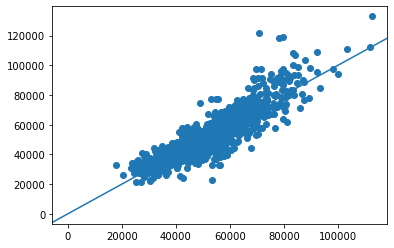

In [15]:
plt.scatter(x = linearSpec.fittedvalues, y = ba_ml['MD_EARN_WNE_P10']);
plt.axline([0, 0], [1, 1]);

## Explore log transformation of target variable

<AxesSubplot:>

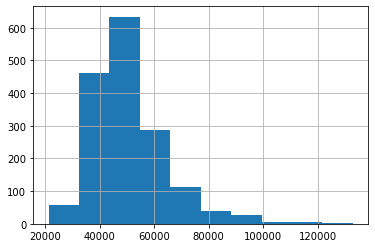

In [16]:
ba_ml['MD_EARN_WNE_P10'].hist()

The earnings distribution has a longer right tail and is skewed. A log transform would center the distribution more.

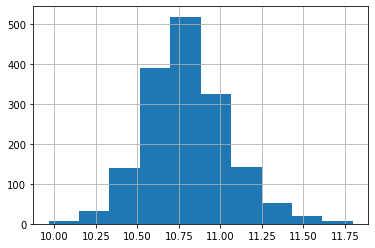

In [17]:
ba_ml['logEarn10'] = np.log(ba_ml['MD_EARN_WNE_P10'])
ba_ml['logEarn10'].hist();

In [18]:
ba_ml['logEarn10'].describe()

count    1631.000000
mean       10.800365
std         0.248652
min         9.964489
25%        10.644996
50%        10.782969
75%        10.942730
max        11.797871
Name: logEarn10, dtype: float64

In [19]:
np.exp(ba_ml['logEarn10'].mean())

49038.68289824949

The mean of the log is the same as the log of the mean so exponentiation of the mean does not return the original mean. Running the same regression equation except with the log of earnings slightly increases the $R^2$ to 80 percent.

In [20]:
linearSpec = specRegression(X = ba_ml[inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]]+ econ_var],
y = ba_ml['logEarn10'], addConstant=0)

linearSpec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logEarn10   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     145.5
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:39:31   Log-Likelihood:                 1259.3
No. Observations:                1631   AIC:                            -2431.
Df Residuals:                    1587   BIC:                            -2193.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
admrate                -0.0204      0.018     -1.111      0.267      -0.056       0.016
C150_4                  0.1271      0.028      4.508      0.000       0.072       0.182
RET_FT4                 0.1242      0.034      3.632      0.000       0.057       0.191
Private for-profit      8.4242      0.083    101.826      0.000       8.262       8.586
Private nonprofit       8.4188      0.082    103.100      0.000       8.259       8.579
Public                  8.3732      0.082    101.945      0.000       8.212       8.534
ccbasic_15              1.4025      0.024     59.582      0.000       1.356       1.449
ccbasic_16              1.4503      0.022     67.037      0.000       1.408       1.493
ccbasic_17              1.4630      0.021     69.221      0.000       1.422       1.504
ccbasic_18              1.4696      0.019     75.576      0.000       1.431       1.508
ccbasic_19              1.4810      0.020     73.663      0.000       1.442       1.520
ccbasic_20              1.4356      0.021     68.254      0.000       1.394       1.477
ccbasic_21              1.4708      0.020     72.015      0.000       1.431       1.511
ccbasic_22              1.4533      0.019     76.619      0.000       1.416       1.491
ccbasic_23              1.4434      0.043     33.877      0.000       1.360       1.527
ccbasic_24              1.4284      0.029     48.795      0.000       1.371       1.486
ccbasic_25          -5.188e-11   3.42e-12    -15.181      0.000   -5.86e-11   -4.52e-11
ccbasic_26              1.6753      0.028     59.196      0.000       1.620       1.731
ccbasic_27              1.6409      0.068     24.065      0.000       1.507       1.775
ccbasic_28              1.6844      0.057     29.401      0.000       1.572       1.797
ccbasic_29              1.4486      0.034     42.887      0.000       1.382       1.515
ccbasic_30              1.5446      0.030     52.310      0.000       1.487       1.603
ccbasic_31          -2.725e-15   6.89e-16     -3.956      0.000   -4.08e-15   -1.37e-15
ccbasic_32              1.4010      0.058     24.045      0.000       1.287       1.515
ccbasic_33              1.3235      0.152      8.686      0.000       1.025       1.622
AVGFACSAL            2.639e-05   2.33e-06     11.308      0.000    2.18e-05     3.1e-05
PFTFAC                 -0.0063      0.013     -0.489      0.625      -0.031       0.019
PCTPELL                -0.4035      0.041     -9.728      0.000      -0.485      -0.322
UGDS_WOMEN             -0.1423      0.029     -4.986      0.000      -0.198      -0.086
UGDS_WHITE              0.0286      0.053      0.541      0.588      -0.075       0.132
UGDS_BLACK              0.0084      0.054      0.155      0.877      -0.097       0.114
UGDS_HISP               0.1940      0.057      3.428      0.001       0.083       0.305
UGD

In [21]:
np.sqrt(sum((linearSpec.resid)**2)/linearSpec.nobs), np.sqrt(linearSpec.mse_resid)

(0.11179877937093491, 0.11333800897337452)

Similarly we can compute the RMSE of the linear model. In log terms the error is around 0.11. How does this translate in to dollar values? This can be done by exponentiating the fitted values and the log earnings which gives predicted and actual earnings respectively. The RMSE can then be computed using the usual formula.

In [22]:
np.sqrt(sum((np.exp(linearSpec.fittedvalues)-np.exp(ba_ml['logEarn10']))**2)/linearSpec.nobs)

6045.989123400345

Transforming the target variable into log form improves the prediction of the linear model. The $300 difference in average error is about 12 percent which is not a large improvement in percentage terms compared when compared to either the overall mean or median of earnings.

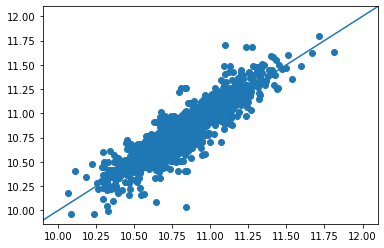

In [23]:
plt.scatter(x = linearSpec.fittedvalues, y = ba_ml['logEarn10']);
plt.axline([10, 10], [12, 12]);

In [24]:
ba_ml['linear_fit'] = linearSpec.fittedvalues

## Machine learning approach

The ML approach is preferred if the goal is to predict the outcome. The 'traditional' analytics approach uses the entire data set and likely would overfit the model. This implies that the model would not predict well out of sample.

### Preprocessing

In [25]:
from sklearn.preprocessing import StandardScaler

def createTrainTest(df, size, rs=402, Xvar=inst_char + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]] + econ_var):
    y = df['logEarn10']
    X = df[Xvar]
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=size,random_state=rs)
    scaler = StandardScaler().fit(train_X)
    train_X_std, test_X_std, X_std = scaler.transform(train_X), scaler.transform(test_X), scaler.transform(X)

    return (train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y)

train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml, 0.3)

### ML algorithms

Several machine learning algorithms are considered.
1. Linear models:
    - Linear regression
    - Bayesian ridge regression
    - Ridge regression
    - Lasso
    - Lasso with Least Angle Regression
    - ElasticNet
    - Automatic relevance detection regression
    - Ridge regression with cross validation
2. Survey vector regression
3. Decision tree regressor
4. Nearest neighbor
5. Ensemble methods:
    - Random forest regressor
    - AdaBoost
    - Gradient boosting

In [26]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

def get_cross(model, data, target, groups=10):
    return cross_val_score(model, data, target, cv=groups, scoring='neg_mean_squared_error')

### Using default parameters from sklearn

The algorithms are evaluated in two ways:
1. The error on the hold-out test data set
2. Cross validation error using 10-folds on the entire data set.

As is common practice performance is evaluated using the test data with the cross-validation presented for comparison purposes. Also presented are results using scaled and unscaled features. Since the scale of the features can impact some ML algorithms, results using standardized features are evaluated rather than unscaled features.

In [27]:
# From david paper: Chapter 4 if Hands On Machine Learning Applications: Data Science Fundamentals with Python
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor as rfr, AdaBoostRegressor as ada, GradientBoostingRegressor as gbr
from sklearn.linear_model import LinearRegression as lr, BayesianRidge as bay, Ridge as rr, Lasso as l, LassoLars as ll, ElasticNet as en, ARDRegression as ard, RidgeCV as rcv
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.neighbors import KNeighborsRegressor as knn

regressors = [lr(), 
bay(), 
rr(alpha=.5, random_state=0), 
l(alpha=0.1, random_state=0), 
ll(), 
knn(), 
ard(), 
rfr(random_state=0, n_estimators=100),
SVR(gamma='scale', kernel="linear"),
rcv(fit_intercept=False), 
en(random_state=0),
dtr(random_state=0), 
ada(random_state=0),
gbr(random_state=0)]

def get_error(model, Xtest, ytest):
    y_pred = model.predict(Xtest)
    return np.sqrt(mean_squared_error(ytest, y_pred)), model.__class__.__name__

def getMLresults(trainX, trainY, testX, testY, Type, runType):
    for reg in regressors:
        reg.fit(trainX, trainY)
        # test error
        rmse, name = get_error(reg, testX, testY)
        # cross-validation error using training
        scores = get_cross(reg, trainX, trainY)
        cverr = np.sqrt(np.mean(np.abs(scores)))
        name = reg.__class__.__name__
        results.append({Type: runType, 'method': name, 'error': rmse, 'cverr': cverr})

    return results

results = []
br = '\n'
# print ('unscaled:', br)
results = getMLresults(train_X, train_y, test_X, test_y, 'Scaled', 'No')

# print ('scaled:', br)
results = getMLresults(train_X_std, train_y, test_X_std, test_y, 'Scaled', 'Yes')
results = pd.DataFrame(results)

In [28]:
pd.set_option('display.float_format', lambda x: '%8.6f' % x)
results.sort_values(['Scaled','error'], ascending=True).groupby('Scaled').head(30)

,Scaled,method,error,cverr
2,No,Ridge,0.131105,0.113229
13,No,GradientBoostingRegressor,0.131417,0.111430
1,No,BayesianRidge,0.131895,0.112760
0,No,LinearRegression,0.134149,0.112673
7,No,RandomForestRegressor,0.139055,0.119025
6,No,ARDRegression,0.142191,0.120496
12,No,AdaBoostRegressor,0.149424,0.136828
3,No,Lasso,0.162505,0.155364
10,No,ElasticNet,0.171368,0.168965
9,No,RidgeCV,0.178886,0.214434


In all cases, the ML approach does not have a lower RMSE than the traditional analytical approach. As expected the out of sample RMSE for the linear regression is 0.13 which is higher than the traditional approach. Looking at the test errors using scaled data, linear models appear to have similar out of sample errors - the lowest is the gradient boosted and ARD regression with an out-of-sample error of 0.13 and the highest is the ridge regression with cross validation at 10.8. 

Among the ensemble learning approaches, the gradient boosting regressor has the best predictive ability with an out-of-sample error of 0.13 although the difference is small compared to the other regression approaches. Using 10-fold cross-validation on the training data set mostly preserves the ranking of errors computed using the test data. One surprise is the large error using linear regression and cross validation.

Based on the above three regressors, tuning using cross validation on the test data set does not appear to improve the predictive ability of the ML approaches. Note: David Paper's book cross validates on the entire data set which is not the approach taken here.

### Tuning and scoring within GridSearchCV

Instead of tuning each algorithm and scoring on the test data, we can also score on the entire data. Instead of defining each algorithm separately, grid search is used.

In [29]:
tune_reg = [l(), rfr(), knn(), ll(), en(), gbr(), ard()]
alpha = [0.005, 0.01, 0.1]
n_estimators = [10, 50, 100]
knn_num = [5, 10, 15, 20]
alpha_ = [1e-6, 1e-10, 1e-4, 1e-2]
lambda_ = [1e-6, 1e-10, 1e-4, 1e-2]

tune_params = [{'alpha': alpha, 'random_state': [0]}, 
{'n_estimators': n_estimators, 'random_state': [0]},
{'n_neighbors': knn_num},
{'alpha': alpha, 'random_state': [0]},
{'alpha': alpha, 'random_state': [0], 'l1_ratio': [0.1, 0.5, 0.9]},
{'n_estimators': n_estimators, 'random_state': [0]},
{'alpha_1': alpha_, 'alpha_2': alpha_, 'lambda_1': lambda_, 'lambda_2': lambda_}]

def GS(trainX, trainY, testX, testY, X, y):
    for reg, tune in zip(tune_reg, tune_params):
        grid = GridSearchCV(reg, tune, cv=10, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', refit=True)
        grid.fit(trainX, trainY)
        # print ("Best parameters: ", reg.__class__.__name__, br, grid.best_params_, br)
        # print()
        y_true, y_pred = testY, grid.predict(testX)
        testError = np.sqrt(mean_squared_error(y_true, y_pred))
        # print(np.sqrt(mean_squared_error(y_true, y_pred)))
        # print()
        y_true, y_pred = y, grid.predict(X)
        fullDataError = np.sqrt(mean_squared_error(y_true, y_pred))
        # print(np.sqrt(mean_squared_error(y_true, y_pred)))
        results.append({'Name': reg.__class__.__name__, 'Best param': grid.best_params_, 
        'Test error': testError, 'Full error': fullDataError})

    return results

results = []
results = GS(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y, X=X_std, y=y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 256 candidates, totalling 2560 fits


In [30]:
pd.DataFrame(results).sort_values('Full error')

,Name,Best param,Test error,Full error
1,RandomForestRegressor,"{'n_estimators': 100, 'random_state': 0}",0.139044,0.084907
5,GradientBoostingRegressor,"{'n_estimators': 100, 'random_state': 0}",0.131414,0.091945
4,ElasticNet,"{'alpha': 0.005, 'l1_ratio': 0.1, 'random_stat...",0.132740,0.114224
6,ARDRegression,"{'alpha_1': 1e-10, 'alpha_2': 0.01, 'lambda_1'...",0.133594,0.114332
0,Lasso,"{'alpha': 0.005, 'random_state': 0}",0.132456,0.117243
2,KNeighborsRegressor,{'n_neighbors': 5},0.156390,0.123917
3,LassoLars,"{'alpha': 0.005, 'random_state': 0}",0.225350,0.234672


The two best performing algorithms were the random forest regressor (based on full data error) and the gradient boosted regressor (based on the test data error). We look at the actual versus predicted values of each of these compared to the "traditional" linear regression model.

#### The random forest regressor

In [31]:
def randomForest(trainX, trainY, X, y, nest=100):
    rf = rfr(random_state=0, n_estimators=nest)
    rf.fit(trainX, trainY)

    y_pred = rf.predict(X)
    return (y_pred, np.sqrt(mean_squared_error(y, y_pred)), rf)

y_pred_rfr, best_rmse_rfr, rfobj = randomForest(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
best_rmse_rfr

0.08490717285159062

#### The gradient boosting algorithm

In [32]:
def gboost(trainX, trainY, X, y, nest=100):
    gb = gbr(random_state=0, n_estimators=nest)
    gb.fit(trainX, trainY)

    y_pred = gb.predict(X)
    return (y_pred, np.sqrt(mean_squared_error(y, y_pred)), gb)

y_pred_gbr, best_rmse_gbr, gbobj = gboost(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
best_rmse_gbr

0.0919445180026019

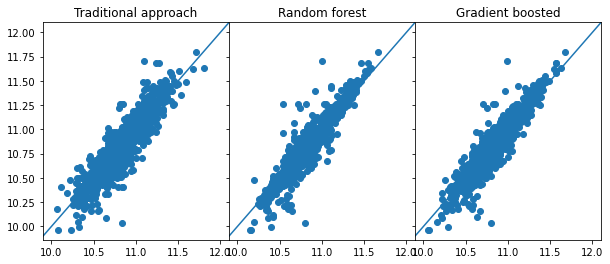

In [33]:
fig, [trad_ax, rfr_ax, gb_ax] = plt.subplots(nrows=1, ncols=3, sharey=True, gridspec_kw={'width_ratios':[2,2,2]}, figsize=(10,4))
plt.subplots_adjust(wspace=0.0)

trad_ax.scatter(x = linearSpec.fittedvalues, y = np.log(ba_ml['MD_EARN_WNE_P10']));
trad_ax.axline([10, 10], [12, 12]);
trad_ax.set_title("Traditional approach");

rfr_ax.scatter(x = y_pred_rfr, y = y);
rfr_ax.axline([10, 10], [12, 12]);
rfr_ax.set_title("Random forest");

gb_ax.scatter(x = y_pred_gbr, y = y);
gb_ax.axline([10, 10], [12, 12]);
gb_ax.set_title("Gradient boosted");

In [34]:
ba_ml['pred_rfr'] = y_pred_rfr
ba_ml['pred_gbr'] = y_pred_gbr

While the MSE does not indicate a large improvement, the predicted versus actual values have a tighter fit for the random forest and gradient boosted regressor.

### Adding polynomial features

In [35]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
p = poly.fit(ba_ml[inst_char + inst_qual + inst_major + inst_ugdschar + [test_scores[0]]])
pfeatures = poly.transform(ba_ml[inst_char + inst_qual + inst_major + inst_ugdschar + [test_scores[0]]])
pfeatures = pd.DataFrame(pfeatures, columns = poly.get_feature_names_out())
c = inst_char + ccbasic + econ_var + ['logEarn10']
for var in c:
    pfeatures[var] = ba_ml[var].to_numpy()

allfeatures = inst_char + list(poly.get_feature_names_out()) + econ_var

train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(pfeatures, 0.3, Xvar=allfeatures)
y_pred, rmse, rfobj = randomForest(trainX=train_X_std, trainY=train_y, X=X_std, y=y)

ba_ml['pred_rfr_poly'] = y_pred
rmse

0.08262444984737544

In [36]:
y_pred, rmse, gbobj = gboost(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
ba_ml['pred_gbr_poly'] = y_pred
rmse

0.08993442499696673

In [37]:
ba_ml.to_pickle('ba_ml_model1a.pkl')

In [43]:
ba_pred = ba_ml[['UNITID', 'INSTNM', 'STABBR', 'Public', 'Private nonprofit', 'Private for-profit', 'logEarn10', 'linear_fit', 'pred_rfr', 'pred_gbr', 'pred_rfr_poly', 'pred_gbr_poly']].set_index('UNITID')
ba_pred['resid_linear'] = ba_pred['linear_fit'] - ba_pred['logEarn10'] 
ba_pred['resid_rfr'] = ba_pred['pred_rfr'] - ba_pred['logEarn10'] 
ba_pred['resid_gbr'] = ba_pred['pred_gbr'] - ba_pred['logEarn10'] 
ba_pred['resid_rfr_poly'] = ba_pred['pred_rfr_poly'] - ba_pred['logEarn10'] 
ba_pred['resid_gbr_poly'] = ba_pred['pred_gbr_poly'] - ba_pred['logEarn10'] 
ba_pred['pct_logearn'] = ba_pred['logEarn10'].rank(pct=True, ascending=False)
ba_pred['pct_linear'] = ba_pred['resid_linear'].rank(pct=True)
ba_pred['pct_rfr'] = ba_pred['resid_rfr'].rank(pct=True)
ba_pred['pct_gbr'] = ba_pred['resid_gbr'].rank(pct=True)
ba_pred['pct_rfr_poly'] = ba_pred['resid_rfr_poly'].rank(pct=True)
ba_pred['pct_gbr_poly'] = ba_pred['resid_gbr_poly'].rank(pct=True)

ba_pred.to_pickle('ba_pred_model1a.pkl')
ba_pred.to_csv('ba_pred_model1a.csv')

### Explore using SAT instead of ACT


In [17]:
linearSpec = specRegression(X = ba_ml[inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[3]]+ econ_var],
y = ba_ml['MD_EARN_WNE_P10'], addConstant=0)

linearSpec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     135.8
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:16:18   Log-Likelihood:                -16572.
No. Observations:                1631   AIC:                         3.323e+04
Df Residuals:                    1587   BIC:                         3.347e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
admrate             -1609.0430   1033.137     -1.557      0.120   -3635.500     417.415
C150_4               7317.3683   1575.845      4.643      0.000    4226.412    1.04e+04
RET_FT4              6315.7036   1914.727      3.298      0.001    2560.042    1.01e+04
Private for-profit    690.5873   4966.969      0.139      0.889   -9051.924    1.04e+04
Private nonprofit     576.0042   4936.947      0.117      0.907   -9107.619    1.03e+04
Public              -3039.0401   4966.099     -0.612      0.541   -1.28e+04    6701.765
ccbasic_15          -5602.6660   1359.062     -4.122      0.000   -8268.411   -2936.921
ccbasic_16          -3478.3910   1253.164     -2.776      0.006   -5936.423   -1020.359
ccbasic_17          -2697.6042   1219.836     -2.211      0.027   -5090.264    -304.945
ccbasic_18          -2290.9813   1131.909     -2.024      0.043   -4511.175     -70.787
ccbasic_19          -1527.2115   1172.706     -1.302      0.193   -3827.428     773.005
ccbasic_20          -3504.2514   1218.971     -2.875      0.004   -5895.214   -1113.289
ccbasic_21          -2141.8728   1180.387     -1.815      0.070   -4457.155     173.410
ccbasic_22          -2215.2022   1102.386     -2.009      0.045   -4377.487     -52.917
ccbasic_23          -1846.4975   2387.322     -0.773      0.439   -6529.134    2836.139
ccbasic_24          -1648.0097   1652.560     -0.997      0.319   -4889.440    1593.421
ccbasic_25           2.496e-08   6.41e-08      0.389      0.697   -1.01e-07    1.51e-07
ccbasic_26           1.215e+04   1631.112      7.451      0.000    8953.663    1.54e+04
ccbasic_27           1.644e+04   3845.563      4.276      0.000    8901.310     2.4e+04
ccbasic_28           8234.6452   3238.582      2.543      0.011    1882.297    1.46e+04
ccbasic_29          -3706.5890   1917.298     -1.933      0.053   -7467.291      54.113
ccbasic_30           2394.5430   1686.249      1.420      0.156    -912.967    5702.053
ccbasic_31           1.302e-11   5.63e-12      2.312      0.021    1.97e-12    2.41e-11
ccbasic_32          -5694.8971   3295.459     -1.728      0.084   -1.22e+04     769.013
ccbasic_33          -4644.7154   8524.862     -0.545      0.586   -2.14e+04    1.21e+04
AVGFACSAL               1.6640      0.130     12.751      0.000       1.408       1.920
PFTFAC               -115.3594    718.039     -0.161      0.872   -1523.765    1293.046
PCTPELL             -1.919e+04   2259.742     -8.494      0.000   -2.36e+04   -1.48e+04
UGDS_WOMEN          -8877.5226   1594.694     -5.567      0.000    -1.2e+04   -5749.595
UGDS_WHITE            888.7527   2955.659      0.301      0.764   -4908.654    6686.160
UGDS_BLACK           1747.9767   3018.005      0.579      0.563   -4171.719    7667.672
UGDS_HISP            6242.6128   3165.405      1.972      0.049      33.798    1.25e+04
UGD

In [18]:
np.sqrt(sum((linearSpec.resid)**2)/linearSpec.nobs), np.sqrt(linearSpec.mse_resid)

(6257.328494217158, 6343.478497863724)

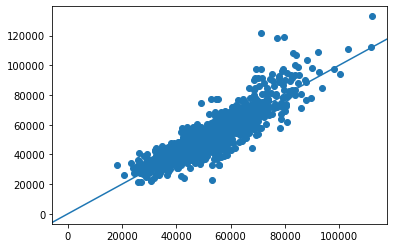

In [19]:
plt.scatter(x = linearSpec.fittedvalues, y = ba_ml['MD_EARN_WNE_P10']);
plt.axline([0, 0], [1, 1]);

In [23]:
linearSpec = specRegression(X = ba_ml[inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[3]]+ econ_var],
y = ba_ml['logEarn10'], addConstant=0)

linearSpec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logEarn10   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     144.5
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:20:00   Log-Likelihood:                 1254.6
No. Observations:                1631   AIC:                            -2421.
Df Residuals:                    1587   BIC:                            -2184.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
admrate                -0.0279      0.019     -1.506      0.132      -0.064       0.008
C150_4                  0.1325      0.028      4.691      0.000       0.077       0.188
RET_FT4                 0.1284      0.034      3.743      0.000       0.061       0.196
Private for-profit      8.4406      0.089     94.838      0.000       8.266       8.615
Private nonprofit       8.4312      0.088     95.308      0.000       8.258       8.605
Public                  8.3835      0.089     94.212      0.000       8.209       8.558
ccbasic_15              1.4086      0.024     57.843      0.000       1.361       1.456
ccbasic_16              1.4542      0.022     64.761      0.000       1.410       1.498
ccbasic_17              1.4672      0.022     67.126      0.000       1.424       1.510
ccbasic_18              1.4722      0.020     72.585      0.000       1.432       1.512
ccbasic_19              1.4830      0.021     70.574      0.000       1.442       1.524
ccbasic_20              1.4379      0.022     65.829      0.000       1.395       1.481
ccbasic_21              1.4757      0.021     69.771      0.000       1.434       1.517
ccbasic_22              1.4555      0.020     73.686      0.000       1.417       1.494
ccbasic_23              1.4496      0.043     33.888      0.000       1.366       1.534
ccbasic_24              1.4329      0.030     48.390      0.000       1.375       1.491
ccbasic_25           2.046e-11   1.15e-12     17.810      0.000    1.82e-11    2.27e-11
ccbasic_26              1.6727      0.029     57.231      0.000       1.615       1.730
ccbasic_27              1.6425      0.069     23.836      0.000       1.507       1.778
ccbasic_28              1.6754      0.058     28.870      0.000       1.562       1.789
ccbasic_29              1.4510      0.034     42.236      0.000       1.384       1.518
ccbasic_30              1.5401      0.030     50.972      0.000       1.481       1.599
ccbasic_31          -8.501e-16   1.01e-16     -8.427      0.000   -1.05e-15   -6.52e-16
ccbasic_32              1.3979      0.059     23.673      0.000       1.282       1.514
ccbasic_33              1.3389      0.153      8.765      0.000       1.039       1.638
AVGFACSAL            2.691e-05   2.34e-06     11.507      0.000    2.23e-05    3.15e-05
PFTFAC                 -0.0062      0.013     -0.484      0.628      -0.031       0.019
PCTPELL                -0.4376      0.040    -10.806      0.000      -0.517      -0.358
UGDS_WOMEN             -0.1349      0.029     -4.721      0.000      -0.191      -0.079
UGDS_WHITE              0.0316      0.053      0.596      0.551      -0.072       0.135
UGDS_BLACK              0.0078      0.054      0.144      0.886      -0.098       0.114
UGDS_HISP               0.1874      0.057      3.304      0.001       0.076       0.299
UGD

In [24]:
np.sqrt(sum((linearSpec.resid)**2)/linearSpec.nobs), np.sqrt(linearSpec.mse_resid)

(0.11212215955998599, 0.11366584141461142)

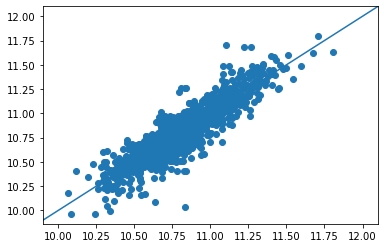

In [25]:
plt.scatter(x = linearSpec.fittedvalues, y = ba_ml['logEarn10']);
plt.axline([10, 10], [12, 12]);

In [31]:
train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml, 0.3, 
Xvar=inst_char + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[3]] + econ_var)

In [32]:
results = []
br = '\n'
# print ('unscaled:', br)
results = getMLresults(train_X, train_y, test_X, test_y, 'Scaled', 'No')

# print ('scaled:', br)
results = getMLresults(train_X_std, train_y, test_X_std, test_y, 'Scaled', 'Yes')
results = pd.DataFrame(results)

In [33]:
results.sort_values(['Scaled','error'], ascending=True).groupby('Scaled').head(30)

,Scaled,method,error,cverr
13,No,GradientBoostingRegressor,0.131876,0.111696
2,No,Ridge,0.132299,0.113261
1,No,BayesianRidge,0.132915,0.112847
0,No,LinearRegression,0.134970,0.112790
7,No,RandomForestRegressor,0.136784,0.118741
6,No,ARDRegression,0.144946,0.120467
12,No,AdaBoostRegressor,0.152522,0.134378
10,No,ElasticNet,0.162407,0.150176
3,No,Lasso,0.163381,0.149853
11,No,DecisionTreeRegressor,0.187677,0.170385
